# Imports

In [1]:
import pandas as pd
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt
import re
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

e:\college\level-4\1st term\NLP\labs\Assignment 1\nlp-assignment-1\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load The Data, Read and map the scores to their classes

In [2]:
# Load the SST dataset's training split
train_data = load_dataset('sst', split='train', trust_remote_code=True)
train_data = pd.DataFrame(train_data)

# Load the SST dataset's validation split
val_data = load_dataset('sst', split='validation', trust_remote_code=True)
val_data = pd.DataFrame(val_data)

# Load the SST dataset's test split
test_data = load_dataset('sst', split='test', trust_remote_code=True)
test_data = pd.DataFrame(test_data)

# concatenate the training and validation data and the test data
data = pd.concat([train_data, val_data, test_data])

del train_data, val_data, test_data

In [3]:
def score_to_class(score):
    if score <= 0.2:
        return 0
    elif score <= 0.4:
        return 1
    elif score <= 0.6:
        return 2
    elif score <= 0.8:
        return 3
    else:
        return 4

def clean_text(text):
    # Remove non-alphabetic characters and lowercase the text
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove words with 2 or fewer characters
    text = re.sub(r'\b\w{1,2}\b', '', text)
    # Remove consecutive spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply cleaning and score mapping on each dataset
data['sentence'] = data['sentence'].apply(lambda x: clean_text(x.lower()))
data['label'] = data['label'].apply(lambda x: score_to_class(x))

# Display cleaned samples from each data
print("Data samples after cleaning:")
print(data.head())

Data samples after cleaning:
                                            sentence  label  \
0  the rock destined the century new conan and th...      3   
1  the gorgeously elaborate continuation the lord...      4   
2  singercomposer bryan adams contributes slew so...      3   
3  you think now america would have had enough pl...      2   
4                    yet the act still charming here      3   

                                              tokens  \
0  The|Rock|is|destined|to|be|the|21st|Century|'s...   
1  The|gorgeously|elaborate|continuation|of|``|Th...   
2  Singer\/composer|Bryan|Adams|contributes|a|sle...   
3  You|'d|think|by|now|America|would|have|had|eno...   
4               Yet|the|act|is|still|charming|here|.   

                                                tree  
0  70|70|68|67|63|62|61|60|58|58|57|56|56|64|65|5...  
1  71|70|69|69|67|67|66|64|63|62|62|61|61|58|57|5...  
2  72|71|71|70|68|68|67|67|66|63|62|62|60|60|58|5...  
3  36|35|34|33|33|32|30|29|27|26|25

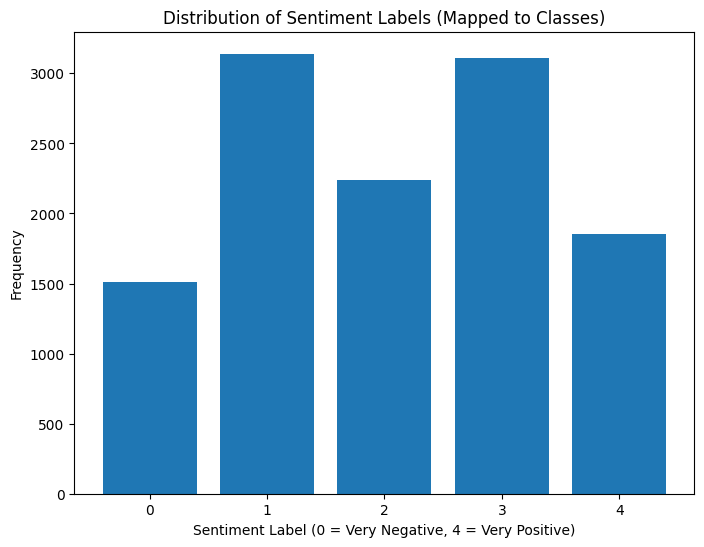

In [4]:
# Plotting the distribution of sentiment labels after mapping scores to classes
data_label_counts = data['label'].value_counts().sort_index()
plt.figure(figsize=(8, 6))
plt.bar(data_label_counts.index, data_label_counts.values)
plt.xlabel("Sentiment Label (0 = Very Negative, 4 = Very Positive)")
plt.ylabel("Frequency")
plt.title("Distribution of Sentiment Labels (Mapped to Classes)")
plt.show()

In [5]:
#divide the data into training 90% and testing 10% so that both have the same distribution of sentiment labels
train_data, test_data = train_test_split(data, test_size=0.1, stratify=data['label'], random_state=42)
del data

# Display a few samples from the train and test sets to verify the split
print("Training data samples:")
print(train_data.head())
print("\nTesting data samples:")
print(test_data.head())

# Display the distribution of labels in the training and test sets to verify the stratification
print("\nLabel distribution in training data:")
print(train_data['label'].value_counts(normalize=True))
print("\nLabel distribution in testing data:")
print(test_data['label'].value_counts(normalize=True))

Training data samples:
                                               sentence  label  \
2134  usually when get this much syrup like pancakes...      1   
1053  mattei tiresomely grave and longwinded circula...      0   
6071  goodlooking but relentlessly lowbrow outing pl...      1   
807   fooled the impressive cast list eye see you pu...      0   
2087             sushi for the connoisseurs the macabre      1   

                                                 tokens  \
2134  Usually|when|I|get|this|much|syrup|,|I|like|pa...   
1053  Mattei|is|tiresomely|grave|and|long-winded|,|a...   
6071  Good-looking|but|relentlessly|lowbrow|outing|p...   
807   Do|n't|be|fooled|by|the|impressive|cast|list|-...   
2087        Sushi|for|the|connoisseurs|of|the|macabre|.   

                                                   tree  
2134  30|29|28|27|26|25|25|24|23|21|20|19|18|17|17|2...  
1053  27|23|22|20|20|21|24|19|18|17|16|15|15|26|16|1...  
6071  20|20|21|19|19|17|16|15|14|13|13|18|14|15|16|

# Part 1: Naïve Bayes

In [3]:
def train_naive_bayes(data: pd.DataFrame):
    # Get the number of docs and classes of the data
    n = len(data)
    classes = data['label'].unique().tolist()

    # Construct vocabulary, and count of each word and total word count in each class
    vocab = set()
    vocab_counts = {}
    class_word_counts = {}
    # Loop over each sentence-class pair
    for sentence, c in zip(data['sentence'].tolist(), data['label'].tolist()):
        for word in sentence.split():  # Loop over each word
            vocab_counts[(word, c)] = vocab_counts.get((word, c), 0) + 1  # Increment count of word in that class
            class_word_counts[c] = class_word_counts.get(c, 0) + 1  # Increment number of words in that class
            vocab.add(word)  # Add word to the vocabulary set

    # Calculate log versions of prior probabilities p(c) and posterior probabilities for each word p(w|c)
    log_prior = {}
    log_likelihood = {}
    for c in classes:
        log_prior[c] = np.log(np.sum(data['label'] == c) / n)
        for word in vocab:
            log_likelihood[(word, c)] = np.log(
                (vocab_counts.get((word, c), 0) + 1) / (class_word_counts[c] + len(vocab)))

    return log_prior, log_likelihood, vocab


def test_naive_bayes(test_doc: str, log_prior: dict, log_likelihood: dict, classes: list[int], vocab: set):
    # Initialize all scores to 0
    score = [0] * len(classes)
    # Loop over each class and calculate the score of this class given the test doc
    for c_i, c in enumerate(classes):
        score[c_i] = log_prior[c]  # Initialize score to log prior probability
        # Add likelihood of each word in the sentence given current class (if it was in the vocabulary)
        for word in test_doc.lower().split():
            if word in vocab:
                score[c_i] += log_likelihood[(word, c)]
    # Return class with the max score
    return classes[np.argmax(score)]

# Computing Naïve Bayes Accuracy

In [4]:
log_prior, log_likelihood, vocab = train_naive_bayes(train_data)

classes = train_data['label'].unique().tolist()

correct_predictions = 0
total_predictions = len(test_data)

for sentence, true_label in zip(test_data['sentence'], test_data['label']):
    predicted_label = test_naive_bayes(sentence, log_prior, log_likelihood, classes, vocab)
    if predicted_label == true_label:
        correct_predictions += 1

accuracy = correct_predictions / total_predictions
print(f"Accuracy: {accuracy:.12f}")

Accuracy: 0.401357466063


# Computing Scikit Accuracy

In [5]:
# Prepare training and test datasets (sentence and label)
X_train, y_train = train_data['sentence'], train_data['label']
X_test, y_test = test_data['sentence'], test_data['label']

# Create a pipeline with CountVectorizer and MultinomialNB
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('nb', MultinomialNB())  # Use alpha=1 for Laplace smoothing, same as in the custom model
])

# Train the pipeline on the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.12f}")

Accuracy: 0.409049773756


In [ ]:
# Get confusion matrix with rows as actual classes and columns as predicted classes
def get_confusion_matrix(predicted, actual):
    classes = np.unique(actual)
    n = len(classes)
    confusion_matrix = np.zeros((n, n), dtype=int)
    for a, p in zip(actual, predicted):
        confusion_matrix[a, p] += 1
    return confusion_matrix

# Get macro-averaged precision over all classes
def precision(confusion_matrix):
    avg_precision = 0
    for c in range(confusion_matrix.shape[0]):
        tp = confusion_matrix[c, c]
        fp = np.sum(confusion_matrix[:, c]) - tp
        # Avoid division by zero
        if (tp + fp) > 0:
            avg_precision += tp / (tp + fp)
    return avg_precision / confusion_matrix.shape[0]

# Get macro-averaged recall over all classes
def recall(confusion_matrix):
    avg_recall = 0
    for c in range(confusion_matrix.shape[0]):
        tp = confusion_matrix[c, c]
        fn = np.sum(confusion_matrix[c, :]) - tp
        # Avoid division by zero
        if (tp + fn) > 0:
            avg_recall += tp / (tp + fn)
    return avg_recall / confusion_matrix.shape[0]

# Get macro-averaged F1 score over all classes
def f1_score(confusion_matrix):
    avg_f1 = 0
    for c in range(confusion_matrix.shape[0]):
        tp = confusion_matrix[c, c]
        fp = np.sum(confusion_matrix[:, c]) - tp
        fn = np.sum(confusion_matrix[c, :]) - tp
        # Calculate precision and recall, avoid division by zero in F1 calculation
        if (tp + fp) > 0:
            precision = tp / (tp + fp)
        else:
            precision = 0
        if (tp + fn) > 0:
            recall = tp / (tp + fn)
        else:
            recall = 0
        if (precision + recall) > 0:
            avg_f1 += 2 * (precision * recall) / (precision + recall)
    return avg_f1 / confusion_matrix.shape[0]
